In [1]:
from htm.algorithms import TemporalMemory
from htm_rl.modules.htm.temporal_memory import DelayedFeedbackTM
from htm.bindings.sdr import SDR
import numpy as np
import matplotlib.pyplot as plt
from htm_rl.modules.htm.spatial_pooler import UnionTemporalPooler
import seaborn as sns

import wandb

wandb.login()

wandb: Currently logged in as: irodkin (use `wandb login --relogin` to force relogin)


True

In [2]:
from configs import *  # I'm so sorry for this...


class StupidEncoder:
    def __init__(self, _n_actions, output_size):
        self.n_actions = _n_actions
        self.action_size = int(output_size / _n_actions)
        self.output_size = output_size

    def encode(self, action: int):
        result = np.zeros(self.output_size)
        result[self.action_size * action: self.action_size * (action + 1)] = 1
        return result


def make_sdr(pos: tuple, _shape: tuple) -> SDR:
    result = SDR(_shape)
    numpy_res = result.dense
    numpy_res = np.zeros(_shape)
    numpy_res[pos] = 1
    result.dense = numpy_res
    return result


def make_sdrs(array: np.ndarray, _shape: tuple) -> np.ndarray:
    result = np.ndarray((array.size,), dtype=SDR)
    iterator = 0
    for number in array:
        result[iterator] = make_sdr(number, _shape)
        iterator += 1
    return result


def learn_model(tm: TemporalMemory, sdrs: np.ndarray, num_epochs=10) -> list:
    errors = []
    for epoch in range(num_epochs):
        for sdr in sdrs:
            tm.compute(sdr, learn=True)
            tm.activateDendrites(True)
            errors.append(tm.anomaly)
        tm.compute(SDR(sdrs[0].dense.shape), learn=False)
    return errors


def generate_data(n, n_actions, n_states, randomness=1.0, seed=0):
    raw_data = list()
    np.random.seed(seed)
    seed_seq = np.random.randint(0, n_actions, n_states)
    raw_data.append(seed_seq.copy())
    n_replace = int(n_states * randomness)
    for i in range(1, n):
        new_seq = np.random.randint(0, n_actions, n_states)
        if randomness == 1.0:
            raw_data.append(new_seq)
        else:
            indices = np.random.randint(0, n_states, n_replace)
            seed_seq[indices] = new_seq[indices]
            raw_data.append(seed_seq.copy())
    data = [list(zip(range(n_states), x)) for x in raw_data]
    return raw_data, data


def compute(tm, state, action, learn=True):
    context = state_encoder.encode(state)
    active_input = action_encoder.encode(action)

    tm.set_active_context_cells(context)

    tm.activate_basal_dendrites(learn)
    tm.predict_cells()

    tm.set_active_columns(active_input)
    tm.activate_cells(learn)


def symmetric_diff_sz(set1: np.ndarray, set2: np.ndarray) -> int:
    return np.setdiff1d(set1, set2).size + np.setdiff1d(set2, set1).size


def symmetric_error(_output, _target):
    return symmetric_diff_sz(_output, _target) / np.union1d(_output, _target).size

def representations_intersection_1(dense1, dense2):
    return np.count_nonzero(dense1 * dense2)/np.count_nonzero(dense1)

def run(tm, tp, policy, state_encoder, action_encoder, learn=True, prev_dense=None, whole_active: SDR=None):
    tp_prev_union = tp.getUnionSDR().sparse.copy()
    tp_input = SDR(tp.getNumInputs())
    tp_predictive = SDR(tp.getNumInputs())
    window_size = 1
    window_error = 0
    counter = 0
    for state, action in policy:
        context = state_encoder.encode(state)
        active_input = action_encoder.encode(action)

        tm.set_active_context_cells(context)

        tm.activate_basal_dendrites(learn)

        tm.set_active_feedback_cells(tp.getUnionSDR().sparse)
        tm.activate_apical_dendrites(learn)
        tm.propagate_feedback()

        tm.predict_cells()

        tm.set_active_columns(active_input)
        tm.activate_cells(learn)

        tp_input.sparse = tm.get_active_cells()
        tp_predictive.sparse = tm.get_correctly_predicted_cells()
        tp.compute(tp_input, tp_predictive, learn)

        current_union = tp.getUnionSDR().sparse.copy()

        window_error += symmetric_error(current_union, tp_prev_union)


        my_log = {}
        if prev_dense is not None:
            my_log['new_cells_percent'] = 1 - representations_intersection_1(tp.getUnionSDR().dense, prev_dense)
            my_log['num_in_prev'] = np.count_nonzero(prev_dense)
            my_log['num_in_curr'] = np.count_nonzero(tp.getUnionSDR().dense)

        if whole_active is not None:
            whole_active.dense = np.logical_or(whole_active.dense, tp.getUnionSDR().dense)
            whole_nonzero = np.count_nonzero(whole_active.dense)
            my_log['cells_in_whole'] = np.count_nonzero(tp.getUnionSDR().dense)/whole_nonzero

        if counter % window_size == window_size - 1:
            my_log['difference'] = (window_error / window_size)
            window_error = 0
        wandb.log(my_log)
        tp_prev_union = current_union.copy()

        counter += 1


def run_only_tp(_tp, sequence, _encoder, learn=True):
    prev_union = _tp.getUnionSDR().sparse.copy()

    for element in sequence:
        _input = _encoder.encode(element)
        sdr = SDR(_tp.getNumInputs())
        sdr.dense = _input
        _tp.compute(sdr, sdr, True)
        diff = symmetric_error(prev_union, _tp.getUnionSDR().sparse)
        wandb.log({'difference': diff})


def get_one_hot(num, _classes_num=25):
    _data = np.zeros(_classes_num)
    _data[num] = 1
    return _data


row_data, data = generate_data(5, n_actions, n_states, randomness=0.5)


In [3]:
errors = []
wandb.init(project='my_utp', entity='irodkin', reinit=True)
tm = DelayedFeedbackTM(**config_tm)
tp = UnionTemporalPooler(**config_tp)

for i in range(100):
    run(tm, tp, data[0], state_encoder, action_encoder, True)
wandb.finish()

KeyboardInterrupt: 

In [79]:
tm = DelayedFeedbackTM(**config_tm)
tp = UnionTemporalPooler(**config_tp)
# errors = run(tm, tp, data[0], state_encoder, action_encoder)
# print(data)
# print(errors)

Text(0.5, 1.0, 'tp_one_policy_errors')

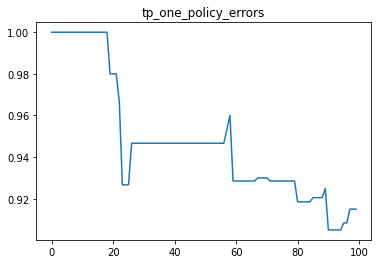

In [11]:
plt.plot(range(len(errors)), errors)
plt.title('tp_one_policy_errors')

In [10]:
from configs import *


class MyUTP:
    _initial_pooling = 1
    _pooling_decay = 0.1

    def __init__(self, **utp_config):
        input_shape = utp_config['inputDimensions']
        output_shape = utp_config['columnDimensions']
        out_size = np.prod(output_shape)
        in_size = np.prod(input_shape)
        self._union_sdr = SDR(output_shape)
        self._pooling_activations = np.zeros(output_shape)
        self._shape = output_shape
        self._initial_pooling = utp_config['initial_pooling']
        self._pooling_decay = utp_config['pooling_decay']
        self._permanence_inc = utp_config['permanence_inc']
        self._permanence_dec = utp_config['permanence_dec']
        self.winners_num = int(np.ceil(utp_config['sparsity'] * out_size))
        self.active_weight = utp_config['active_weight']
        self.predicted_weight = utp_config['predicted_weight']
        self.input_dimensions = input_shape
        self.field_size = int(utp_config['receptive_field_sparsity']*in_size)
        self.activation_threshold = utp_config['activation_threshold']


        self.connections = np.random.normal(self.activation_threshold, 0.1, (out_size, in_size))

        self.receptive_fields = np.zeros((out_size, in_size))
        self.set_receptive_fields()

        self.sensitivity = np.random.uniform(0, 1, (out_size, in_size))

    def set_receptive_fields(self):
        for cell in self.receptive_fields:
            receptive_field = np.random.choice(np.prod(self.input_dimensions), self.field_size, replace=False)
            cell[receptive_field] = 1

    def pooling_decay_step(self):
        self._pooling_activations[self._pooling_activations != 0] -= self._pooling_decay

    def get_active_cells(self, data: np.ndarray) -> SDR:
        tie_breaker = np.random.normal(0, 0.01, self._shape)
        activations = (self.connections*self.sensitivity) @ data + tie_breaker

        most_active = np.argpartition(activations.flatten(), -self.winners_num)[-self.winners_num:]
        result_sdr = SDR(self._shape)
        result_sdr.sparse = most_active
        return result_sdr

    def update_permanences(self, active_neurons: np.ndarray):
        self.connections[:, np.flatnonzero(active_neurons)] -= self._permanence_dec

        active_synapses = np.ix_(self.getUnionSDR().sparse, np.flatnonzero(active_neurons))
        self.connections[active_synapses] += self._permanence_dec
        # self.connections[active_synapses] = (self.connections[active_synapses].transpose()+self._permanence_inc*self._pooling_activations[self.getUnionSDR().sparse]).transpose()
        self.connections[active_synapses] += self._permanence_inc
        self.connections = self.connections.clip(0, 1)

    def compute_continuous(self, active_neurons: SDR, predicted_neurons: SDR, learn: bool = True):
        weighted_input = active_neurons.dense * self.active_weight + predicted_neurons.dense * self.predicted_weight
        winners = self.get_active_cells(weighted_input)
        self.pooling_decay_step()
        self._pooling_activations[winners.sparse] += self._initial_pooling
        self._pooling_activations = self._pooling_activations.clip(0, 1)
        self._union_sdr.dense = self._pooling_activations != 0

        if learn:
            self.update_permanences(active_neurons.dense)

    def count_overlap(self, active_neurons: SDR, predicted_neurons: SDR) -> np.ndarray:
        active_synapses = np.logical_and(
            self.receptive_fields,
            self.connections > self.activation_threshold
        )

        cells_overlap = np.count_nonzero(np.logical_and(
            active_neurons.dense == 1,
            active_synapses
        ), axis=1) * self.active_weight + \
        np.count_nonzero(np.logical_and(
            predicted_neurons.dense == 1,
            active_synapses
        ), axis=1) * self.predicted_weight

        return cells_overlap

    def choose_winners(self, overlap: np.ndarray):
        tie_breaker = np.random.normal(0, 0.01, np.prod(self._shape))
        overlap += tie_breaker
        winners = np.argpartition(overlap,  -self.winners_num)[-self.winners_num:]
        return winners

    def compute(self, active_neurons: SDR, predicted_neurons: SDR, learn: bool = True):
        overlap = self.count_overlap(active_neurons, predicted_neurons)
        winners = self.choose_winners(overlap)

        self.pooling_decay_step()
        self._pooling_activations[winners] += self._initial_pooling
        self._pooling_activations = self._pooling_activations.clip(0, 1)
        self._union_sdr.dense = self._pooling_activations != 0
        if learn:
            self.update_permanences(active_neurons.dense)

    def getUnionSDR(self):
        return self._union_sdr

    def getNumInputs(self):
        return self.input_dimensions

    def reset(self):
        self._pooling_activations = np.zeros(self._pooling_activations.shape)
        self._union_sdr = SDR(self._union_sdr.dense.shape)

def one_hot(num, _classes_num=25):
    _data = np.zeros(_classes_num)
    _data[num] = 1
    return _data


utp_conf = {
    'inputDimensions': [input_columns * cells_per_column],
    'columnDimensions': [output_columns],
    'initial_pooling': 1,
    'pooling_decay': 0.1,
    'permanence_inc': 0.005,
    'permanence_dec': 0.003,
    'sparsity': 0.04,
    'active_weight': 0.5,
    'predicted_weight': 2.0,
    'receptive_field_sparsity' : 0.5,
    'activation_threshold' : 0.6
}
np.random.seed(42)
tp_shape = utp_conf['columnDimensions']
in_shape = utp_conf['inputDimensions']
prev = np.zeros(utp_conf['columnDimensions'])
classes_num = utp_conf['inputDimensions']

my_utp = MyUTP(**utp_conf)

In [68]:
wandb.init(project='my_utp', entity='irodkin', reinit=True, config=utp_conf)

my_utp = MyUTP(**utp_conf)
tm = DelayedFeedbackTM(**config_tm)

for i in range(100):
    run(tm, my_utp, data[0], state_encoder, action_encoder, True)

wandb.finish(quiet=True)

<AxesSubplot:title={'center':'pooling activations'}>

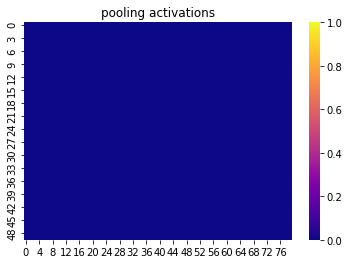

In [8]:
plt.title('pooling activations')
sns.heatmap(my_utp._pooling_activations.reshape(-1, 80), vmin=0, vmax=1, cmap='plasma')

In [40]:
print(my_utp.getUnionSDR().dense.nonzero()[0].size / output_columns)

0.059


In [102]:
wandb.finish()
# tm = DelayedFeedbackTM(**config_tm)

In [67]:
wandb.init(project='my_utp', entity='irodkin', reinit=True, config=utp_conf)

my_utp = MyUTP(**utp_conf)

for i in range(100):
    run_only_tp(my_utp, row_data[0], StupidEncoder(n_actions, utp_conf['inputDimensions'][0]), True)

wandb.finish(quiet=True)

In [14]:
def train_all_seq(tm, tp, data, state_encoder, action_encoder, iters_per_seq):
    representations = []
    prev = tp.getUnionSDR().dense.copy()
    for policy in data:
        whole_active = np.zeros(tp.getUnionSDR().dense.shape)
        for i in range(iters_per_seq):
            if i < 2:
                whole_active = None
            elif i == 2:
                whole_active = SDR(tp.getUnionSDR().dense.shape)
                whole_active.dense = np.zeros(tp.getUnionSDR().dense.shape)
            run(tm, tp, policy, state_encoder, action_encoder, learn=True, prev_dense=prev, whole_active=whole_active)
        representations.append(tp.getUnionSDR())
        prev = tp.getUnionSDR().dense.copy()
        tp.reset()
    return representations

utp_conf = {
    'inputDimensions': [input_columns * cells_per_column],
    'columnDimensions': [output_columns],
    'initial_pooling': 1,
    'pooling_decay': 0.2,
    'permanence_inc': 0.01,
    'permanence_dec': 0.001,
    'sparsity': 0.004,
    'active_weight': 0.5,
    'predicted_weight': 1.0,
    'receptive_field_sparsity' : 0.5,
    'activation_threshold' : 0.6
}

wandb.init(project='my_utp', entity='irodkin', reinit=True, config=utp_conf)


my_utp = MyUTP(**utp_conf)
tm = DelayedFeedbackTM(**config_tm)
tp = UnionTemporalPooler(**config_tp)

representations = train_all_seq(tm, my_utp, data, state_encoder, action_encoder, 20)

wandb.finish(quiet=True)

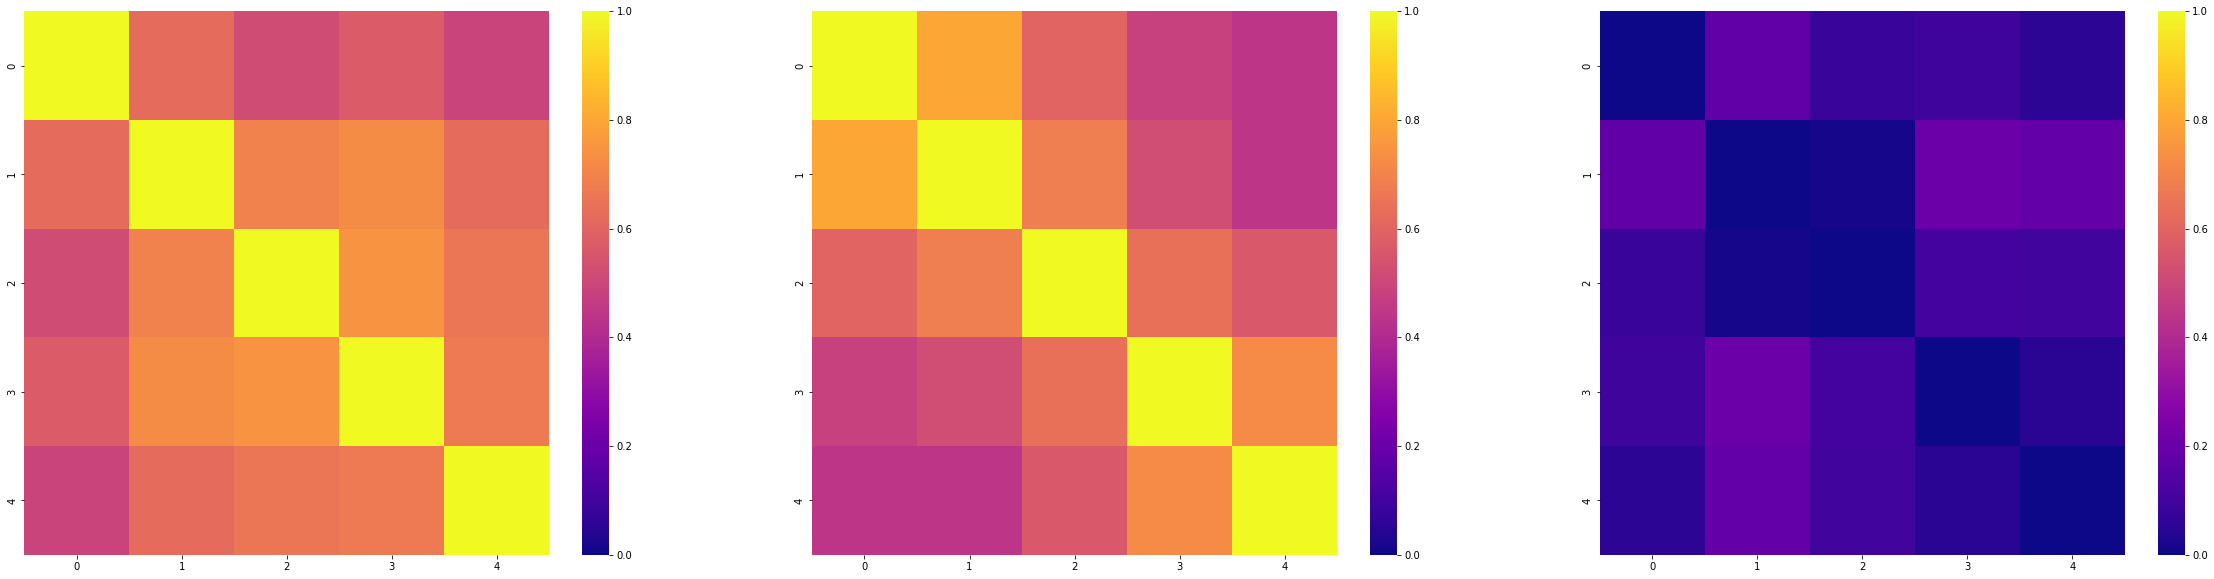

In [15]:
def row_similarity(policy_1, policy_2):
    counter = 0
    for index in range(len(policy_1)):
        if policy_1[index] == policy_2[index]:
            counter += 1
    return counter/len(policy_1)
def representation_similarity(representation_1, representation_2):
    return (representation_1*representation_2).nonzero()[0].size/(representation_1 | representation_2).nonzero()[0].size
similarity_matrix = np.zeros((len(representations), len(representations)))
pure_similarity = np.zeros(similarity_matrix.shape)
for i, policy1 in enumerate(data):
    for j, policy2 in enumerate(data):
        pure_similarity[i][j] = row_similarity(policy1, policy2)
        similarity_matrix[i][j] = abs(
            representation_similarity(representations[i].dense, representations[j].dense)
        )

fig = plt.figure(figsize=(40, 10))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.heatmap(similarity_matrix, vmin=0, vmax=1, cmap='plasma', ax=ax1)
sns.heatmap(pure_similarity, vmin=0, vmax=1, cmap='plasma', ax=ax2)

sns.heatmap(abs(pure_similarity-similarity_matrix), vmin=0, vmax=1, cmap='plasma', ax=ax3)
plt.show()
# print(representations[0].dense.nonzero()[0])
# print(representations[1].dense.nonzero()[0])

In [13]:
a = np.zeros(5)
a[0] = 1
a[2] = 1
b = np.ones(5)
b[1] = 0
print(representations_intersection_1(b, a))

0.5


In [121]:
a = np.ones((3,))
c = SDR([3])
c.dense = a
a = c.dense
a[1] = 0
b = np.random.normal(0, 0.1, (3, 2))
b[1][1] = 0
b[0][0] = 0
b.transpose()
print(a)
print(b)
print((b.transpose()+a).transpose())

[1 0 1]
[[ 0.         -0.08444639]
 [ 0.05977753  0.        ]
 [ 0.04289113  0.00793346]]
[[1.         0.91555361]
 [0.05977753 0.        ]
 [1.04289113 1.00793346]]
